### Key files

reviews.csv - Detailed Review Data for listings in Austin   
listings.csv - Detailed Listings data for Austin   
calendar.csv - Detailed Calendar Data for listings in Austin   
neighbourhoods.csv - Neighbourhood list for geo filter. Sourced from city or open source GIS files.   
neighbourhoods.geojson - GeoJSON file of neighbourhoods of the city.   

Source Data: http://insideairbnb.com/get-the-data.html

### Questions
- From a map perspective, what is the average price per zipcode? Price per person?
- Price based on 'accomomates'
- Price based on 'number of reviews' and 'rating' 


In [38]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#import vincent
#import gdal

# sklearn imports
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

sns.set(style="ticks")
pd.options.mode.chained_assignment = None  # default='warn'
%matplotlib inline

In [39]:
#ogr2ogr -f "GeoJSON" TX_zip.json tl_2010_48_zcta510.shp tl_2010_48_zcta510

In [40]:
#topojson -p -o CA_zip.topo.json CA_zip.json

***
## Gather Data

In [41]:
df_listings = pd.read_csv('listings.csv')

C:\Users\djcummin\anaconda3\envs\py3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (43,61,62) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


***
## Assess Data

In [42]:
df_listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11316 entries, 0 to 11315
Data columns (total 96 columns):
id                                  11316 non-null int64
listing_url                         11316 non-null object
scrape_id                           11316 non-null int64
last_scraped                        11316 non-null object
name                                11315 non-null object
summary                             10989 non-null object
space                               8124 non-null object
description                         11267 non-null object
experiences_offered                 11316 non-null object
neighborhood_overview               6818 non-null object
notes                               4893 non-null object
transit                             6801 non-null object
access                              7168 non-null object
interaction                         6924 non-null object
house_rules                         7469 non-null object
thumbnail_url                 

In [43]:
columns_list = ['room_type', 'price', 'accommodates', 'bathrooms', 'bedrooms',  
                'host_is_superhost', 'neighbourhood_cleansed', 'number_of_reviews', 
                'review_scores_rating', 'minimum_nights', 'listing_url']

df = df_listings[columns_list]

In [44]:
df.head()

,room_type,price,accommodates,bathrooms,bedrooms,host_is_superhost,neighbourhood_cleansed,number_of_reviews,review_scores_rating,minimum_nights,listing_url
0,Entire home/apt,$200.00,4,2.0,2.0,t,78702,22,92.0,2,https://www.airbnb.com/rooms/2265
1,Private room,$125.00,2,1.0,1.0,t,78702,9,91.0,2,https://www.airbnb.com/rooms/5245
2,Entire home/apt,$95.00,3,1.0,1.0,f,78702,441,96.0,2,https://www.airbnb.com/rooms/5456
3,Private room,$40.00,2,1.0,1.0,t,78729,231,98.0,1,https://www.airbnb.com/rooms/5769
4,Entire home/apt,$99.00,2,1.0,NaN,f,78704,75,99.0,3,https://www.airbnb.com/rooms/6413


In [45]:
df.describe()

,accommodates,bathrooms,bedrooms,neighbourhood_cleansed,number_of_reviews,review_scores_rating,minimum_nights
count,11316.000000,11285.000000,11311.000000,11316.000000,11316.000000,8254.000000,11316.000000
mean,4.511046,1.531635,1.777120,78721.957759,21.499116,96.234795,2.686108
std,2.934995,0.846736,1.222437,20.564327,45.642218,7.021552,8.395783
min,1.000000,0.000000,0.000000,78701.000000,0.000000,20.000000,1.000000
25%,2.000000,1.000000,1.000000,78704.000000,0.000000,95.000000,1.000000
50%,4.000000,1.000000,1.000000,78714.500000,4.000000,99.000000,2.000000
75%,6.000000,2.000000,2.000000,78744.000000,21.000000,100.000000,2.000000
max,24.000000,13.500000,17.000000,78759.000000,645.000000,100.000000,365.000000


- Price needs to be converted to float
- Missing NaN needs data imputed or rows removed
- Categorical columns need to be converted to dummy variables (get_dummies)

***
## Clean

In [46]:
# Convert price to from currency to float
df['price'] = df['price'].str.replace('$', '')
df['price'] = df['price'].str.replace(',', '')
df['price'] = df['price'].astype(float)

print("Dataset has {} row entries.".format(df.shape[0]))

Dataset has 11316 row entries.


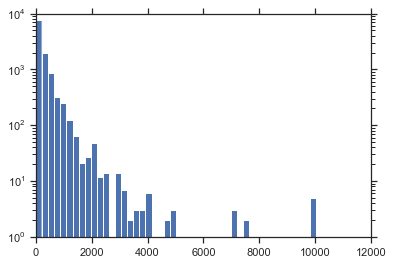

In [47]:
fig, ax = plt.subplots()
fig = plt.hist(df['price'], bins=50)
ax.set_yscale("log", nonposy='clip')
plt.show();

There are some oddly high prices (> $2000) that I want to examine. However, if the rental is a large proporty it would not be fair to discriminate based on price alone. I'll look at price per person (accommodates) to look for outliers. 

In [48]:
df['price_per_person'] = df['price']/df['accommodates']

df['price_per_person'].value_counts().sort_index(ascending=False).head(10)

5000.000000    1
3000.000000    1
1750.000000    1
1500.000000    1
1250.000000    1
1090.000000    1
1000.000000    3
937.500000     1
875.000000     1
833.333333     2
Name: price_per_person, dtype: int64

In [49]:
df.loc[df['price_per_person'] > 1000.00]

,room_type,price,accommodates,bathrooms,bedrooms,host_is_superhost,neighbourhood_cleansed,number_of_reviews,review_scores_rating,minimum_nights,listing_url,price_per_person
626,Private room,7000.0,4,1.0,1.0,f,78749,2,80.0,3,https://www.airbnb.com/rooms/925980,1750.0
4186,Entire home/apt,3000.0,1,NaN,NaN,f,78746,0,NaN,1,https://www.airbnb.com/rooms/11479152,3000.0
4200,Entire home/apt,2500.0,2,1.0,1.0,f,78701,0,NaN,1,https://www.airbnb.com/rooms/11493969,1250.0
4246,Private room,3000.0,2,1.5,1.0,t,78744,9,100.0,1,https://www.airbnb.com/rooms/11548720,1500.0
6454,Private room,10000.0,2,1.0,1.0,f,78723,0,NaN,1,https://www.airbnb.com/rooms/17607193,5000.0
9047,Entire home/apt,10900.0,10,3.0,4.0,t,78704,1,100.0,20,https://www.airbnb.com/rooms/22765762,1090.0


Upon review, the houses listed as with extreme prices were either automated listings with little to no reviews or incorrectly priced at the time of the scrape. I'm opting to remove them from this analysis since they don't pass my common sense as a consumer and Austin native. However, it would be intersting to examine other popular cities to see if they had similar outliers. 

In [50]:
# remove rows with > $1000 per person
df = df.loc[df['price_per_person'] <= 1000.00]
df['price_per_person'].value_counts().sort_index(ascending=False).head()

1000.000000    3
937.500000     1
875.000000     1
833.333333     2
800.000000     1
Name: price_per_person, dtype: int64

In [51]:
df.describe()

,price,accommodates,bathrooms,bedrooms,neighbourhood_cleansed,number_of_reviews,review_scores_rating,minimum_nights,price_per_person
count,11310.000000,11310.000000,11280.000000,11306.000000,11310.000000,11310.000000,8251.000000,11310.000000,11310.000000
mean,271.384527,4.511583,1.531649,1.777198,78721.954642,21.509461,96.235850,2.685146,57.882866
std,455.665751,2.934845,0.846767,1.222441,20.564282,45.652054,7.020309,8.396371,62.074328
min,0.000000,1.000000,0.000000,0.000000,78701.000000,0.000000,20.000000,1.000000,0.000000
25%,80.000000,2.000000,1.000000,1.000000,78704.000000,0.000000,95.000000,1.000000,25.000000
50%,150.000000,4.000000,1.000000,1.000000,78712.000000,4.000000,99.000000,2.000000,40.000000
75%,299.000000,6.000000,2.000000,2.000000,78744.000000,21.000000,100.000000,2.000000,66.666667
max,10000.000000,24.000000,13.500000,17.000000,78759.000000,645.000000,100.000000,365.000000,1000.000000


The review score ratings are missing a lot of data. However, due to the small size of the data set, I'll opt to fill the missing values of the ratings scores at the cost of diluting the ratings feature importance. Before I do this, I'll save a copy of the DataFrame in it's current state since I want to look at a plot of price vs. rating later.

In [52]:
# df for plot later
df_rating_price = df[['review_scores_rating', 'price', 'price_per_person']].copy()
df_rating_price.dropna(inplace=True)

print("Filling missing review scores with {:.3f}.".format(df['review_scores_rating'].mean()))
df['review_scores_rating'].fillna((df['review_scores_rating'].mean()), inplace=True)

Filling missing review scores with 96.236.


The bathrooms feature was missing some data. I'll replace the NaNs based on a rough guess that for every 4 people the rental can accommodate, there is 1 bathroom. 

In [53]:
df[df['bathrooms'].isnull()].head()

,room_type,price,accommodates,bathrooms,bedrooms,host_is_superhost,neighbourhood_cleansed,number_of_reviews,review_scores_rating,minimum_nights,listing_url,price_per_person
81,Entire home/apt,95.0,2,NaN,1.0,t,78735,172,99.00000,3,https://www.airbnb.com/rooms/83322,47.500000
135,Entire home/apt,175.0,5,NaN,3.0,f,78723,1,80.00000,2,https://www.airbnb.com/rooms/247770,35.000000
159,Entire home/apt,350.0,4,NaN,2.0,f,78730,0,96.23585,4,https://www.airbnb.com/rooms/314152,87.500000
161,Entire home/apt,800.0,4,NaN,2.0,f,78701,2,60.00000,1,https://www.airbnb.com/rooms/315328,200.000000
163,Private room,125.0,3,NaN,1.0,f,78759,3,93.00000,1,https://www.airbnb.com/rooms/316885,41.666667


In [54]:
# Bathrooms is getting scaled later, so I do not care about making it a discrete value
# Also 0.5 is commonly known as a 'half-bath'
df['bathrooms'].fillna((df['accommodates']/4), inplace=True)

In [55]:
df.loc[[135]]

,room_type,price,accommodates,bathrooms,bedrooms,host_is_superhost,neighbourhood_cleansed,number_of_reviews,review_scores_rating,minimum_nights,listing_url,price_per_person
135,Entire home/apt,175.0,5,1.25,3.0,f,78723,1,80.0,2,https://www.airbnb.com/rooms/247770,35.0


In [56]:
df.isnull().sum()

room_type                 0
price                     0
accommodates              0
bathrooms                 0
bedrooms                  4
host_is_superhost         3
neighbourhood_cleansed    0
number_of_reviews         0
review_scores_rating      0
minimum_nights            0
listing_url               0
price_per_person          0
dtype: int64

In [57]:
# Drop the few remaining rows with missing values
df.dropna(inplace=True)

The data set severly lacks in samples for larger houses. I'm going to remove some of the extreme rows for these cases since I'm more interested in examining typically sized houses. Another study could be done for very large rental using data from all over the US. 

In [58]:
df['bathrooms'].value_counts().sort_index(ascending=False)

13.50       1
11.50       1
9.50        1
8.50        1
8.00        4
7.50        4
7.00        4
6.50       10
6.00       11
5.50       19
5.00       42
4.50       51
4.00      115
3.50      206
3.00      412
2.50      781
2.00     2195
1.75        1
1.50      656
1.25        1
1.00     6724
0.75        4
0.50       32
0.25        3
0.00       24
Name: bathrooms, dtype: int64

In [59]:
df.groupby('bathrooms').median()

,price,accommodates,bedrooms,neighbourhood_cleansed,number_of_reviews,review_scores_rating,minimum_nights,price_per_person
bathrooms,,,,,,,,
0.00,72.5,2.0,1.0,78738.0,1.0,96.235850,1.0,34.750000
0.25,175.0,1.0,1.0,78722.0,0.0,96.235850,1.0,175.000000
0.50,72.5,2.0,1.0,78730.5,1.0,96.235850,1.0,35.000000
0.75,300.0,3.0,1.0,78727.5,0.0,96.235850,2.0,100.000000
1.00,100.0,3.0,1.0,78705.0,5.0,96.235850,2.0,37.500000
1.25,175.0,5.0,3.0,78723.0,1.0,80.000000,2.0,35.000000
1.50,125.0,4.0,1.0,78723.5,4.0,97.000000,2.0,34.500000
1.75,1000.0,7.0,3.0,78704.0,3.0,100.000000,1.0,142.857143
2.00,236.0,6.0,2.0,78705.0,3.0,96.235850,2.0,41.250000


In [60]:
df['accommodates'].value_counts().sort_index(ascending=False)

24       1
21       2
20       3
18       5
16     148
15      26
14      45
13      17
12     143
11      36
10     379
9       97
8      743
7      277
6     1676
5      694
4     2238
3      971
2     3335
1      467
Name: accommodates, dtype: int64

In [61]:
df.groupby('accommodates').mean()

,price,bathrooms,bedrooms,neighbourhood_cleansed,number_of_reviews,review_scores_rating,minimum_nights,price_per_person
accommodates,,,,,,,,
1,83.432548,1.107602,0.985011,78728.479657,11.531049,95.799928,3.327623,83.432548
2,111.904948,1.078261,0.925337,78725.282459,24.338831,96.309041,2.525637,55.952474
3,147.360453,1.093718,0.985582,78721.725026,29.511843,95.834930,2.571576,49.120151
4,212.621537,1.270777,1.431189,78719.484808,22.347632,96.219759,2.659517,53.155384
5,274.217579,1.500360,1.982709,78720.665706,16.550432,96.074330,3.138329,54.843516
6,337.994033,1.869630,2.403341,78718.022673,19.411098,96.258939,2.902745,56.332339
7,393.350181,2.067690,2.808664,78723.711191,13.299639,96.291329,2.891697,56.192883
8,530.942127,2.384926,3.246299,78720.367429,16.730821,96.571828,2.705249,66.367766
9,526.030928,2.453608,3.360825,78722.835052,14.680412,95.810349,2.659794,58.447881


In [63]:
# Remove extremely large rental listing due to low samples
df = df.loc[df['bathrooms'] <= 8]
df = df.loc[df['accommodates'] <= 16]

I want to sort all of the ZIP codes for Austin the into several regions.

In [64]:
# Compress zipcode into 5 regions for 1 hot encoding
zip_central = [78701, 78702, 78703, 78704, 78705, 78712, 78722]
zip_north = [78726, 78727, 78728, 78729, 78731, 78750, 78751,  
             78756, 78758, 78759, 78757]
zip_west = [78730, 78732, 78733, 78734, 78735, 78736, 78738, 78746]
zip_south = [78737, 78739, 78745, 78749, 78748, 78742]
zip_east = [78717, 78719, 78721, 78723, 78724, 78725, 78741, 
            78744, 78747, 78752, 78753, 78754]

map_dict = {}
str_dict = {0: 'Central', 1: 'North', 2: 'West', 3: 'South', 4: 'East'}
area_list = [zip_central, zip_north, zip_west, zip_south, zip_east]

# Create a dict for the pandas map function to convert zip into region
for i in range(len(area_list)):
    for zipcode in area_list[i]:
        map_dict[zipcode] = str_dict[i]
print(map_dict)    
    
df['region'] = df['neighbourhood_cleansed'].map(map_dict)
df.drop(['neighbourhood_cleansed'], axis=1, inplace=True)

{78701: 'Central', 78702: 'Central', 78703: 'Central', 78704: 'Central', 78705: 'Central', 78712: 'Central', 78722: 'Central', 78726: 'North', 78727: 'North', 78728: 'North', 78729: 'North', 78731: 'North', 78750: 'North', 78751: 'North', 78756: 'North', 78758: 'North', 78759: 'North', 78757: 'North', 78730: 'West', 78732: 'West', 78733: 'West', 78734: 'West', 78735: 'West', 78736: 'West', 78738: 'West', 78746: 'West', 78737: 'South', 78739: 'South', 78745: 'South', 78749: 'South', 78748: 'South', 78742: 'South', 78717: 'East', 78719: 'East', 78721: 'East', 78723: 'East', 78724: 'East', 78725: 'East', 78741: 'East', 78744: 'East', 78747: 'East', 78752: 'East', 78753: 'East', 78754: 'East'}


***
## Analyze & Visualize

### Rental Pricing by Region

In [65]:
df.groupby('region').price.median()

region
Central    179.0
East        99.0
North      100.0
South      102.0
West       239.0
Name: price, dtype: float64

In [66]:
df.groupby('region').price.mean()

region
Central    313.308709
East       176.188241
North      179.420051
South      180.492726
West       443.894040
Name: price, dtype: float64

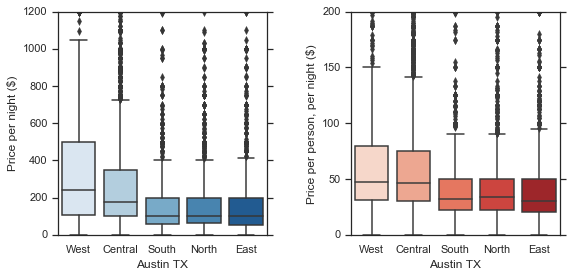

In [67]:
fig, ax = plt.subplots(figsize=(9, 4), ncols=2)

sns.boxplot(x="region", y="price", 
            order=["West", "Central", "South", "North", "East"], 
            ax=ax[0], data=df, palette="Blues")
ax[0].set_xlabel("Austin TX")
ax[0].set_ylabel("Price per night ($)")
ax[0].set_ylim(0, 1200)
ax[0].tick_params(axis='x', which='both', bottom=False, top=False) 

sns.boxplot(x="region", y="price_per_person", 
            order=["West", "Central", "South", "North", "East"], 
            ax=ax[1], data=df, palette="Reds")
ax[1].set_xlabel("Austin TX")
ax[1].set_ylabel("Price per person, per night ($)")
ax[1].set_ylim(0, 200)
ax[1].tick_params(axis='x', which='both', bottom=False, top=False) 

fig.subplots_adjust(wspace=0.4)
fig.savefig('test.png')

### Price based on rental property size

The strongest positive correlation with median price is 'bathrooms', followed by bedroom and accommodates. 

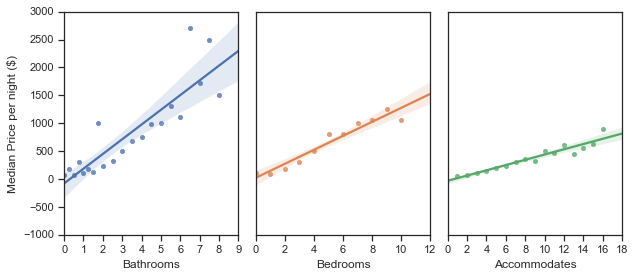

In [68]:
df_grp_bath = df.groupby('bathrooms').price.median().reset_index()
df_grp_bed = df.groupby('bedrooms').price.median().reset_index()
df_grp_acc = df.groupby('accommodates').price.median().reset_index()

fig, ax = plt.subplots(figsize=(10, 4), ncols=3)

sns.regplot(x='bathrooms', y='price', 
            data=df_grp_bath, ax=ax[0])
ax[0].set_xlim(0, None)
ax[0].set_xlabel("Bathrooms")
ax[0].set_ylabel("Median Price per night ($)")

sns.regplot(x='bedrooms', y='price', 
            data=df_grp_bed, ax=ax[1])
ax[1].set_xlim(0, None)
ax[1].set_xlabel("Bedrooms")
ax[1].set_yticks([])
ax[1].yaxis.label.set_visible(False)

sns.regplot(x='accommodates', y='price', 
            data=df_grp_acc, ax=ax[2])
ax[2].set_xlim(0, None)
ax[2].set_xlabel("Accommodates")
ax[2].set_yticks([])
ax[2].yaxis.label.set_visible(False)
 
for a in ax:
    a.set_ylim(-1000, 3000)
    a.tick_params(top=False, right=False) 
    
fig.subplots_adjust(wspace=0.1)
fig.savefig('median_price_compare.png')

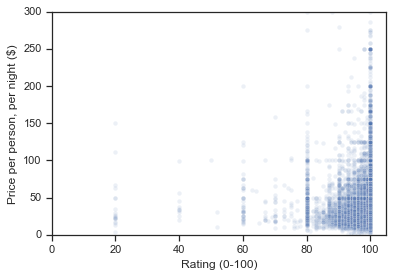

In [94]:
f, ax = plt.subplots()
hack = df_rating_price[df_rating_price['price']>1]

sns.scatterplot(x="review_scores_rating", y='price_per_person', data=hack, ax=ax, alpha=0.1)
ax.set_ylim(0, 300)
ax.set_xlim(0, 105)
ax.set_ylabel("Price per person, per night ($)")
ax.set_xlabel("Rating (0-100)")
ax.tick_params(right=False, top=False) 

***
## Prediction Modeling

In [95]:
features_list = ['room_type', 'bathrooms', 'bedrooms', 'accommodates', 
                 'host_is_superhost',  'region', 'review_scores_rating']

# Create features and price DFs for sklearn inputs
features = df[features_list].copy()   # 'X'
price = df['price'].copy()            # 'y'

In [96]:
features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11288 entries, 0 to 11315
Data columns (total 7 columns):
room_type               11288 non-null object
bathrooms               11288 non-null float64
bedrooms                11288 non-null float64
accommodates            11288 non-null int64
host_is_superhost       11288 non-null object
region                  11288 non-null object
review_scores_rating    11288 non-null float64
dtypes: float64(3), int64(1), object(3)
memory usage: 705.5+ KB


In [97]:
features = pd.get_dummies(features)
features.head()

,bathrooms,bedrooms,accommodates,review_scores_rating,room_type_Entire home/apt,room_type_Private room,room_type_Shared room,host_is_superhost_f,host_is_superhost_t,region_Central,region_East,region_North,region_South,region_West
0,2.0,2.0,4,92.0,1,0,0,0,1,1,0,0,0,0
1,1.0,1.0,2,91.0,0,1,0,0,1,1,0,0,0,0
2,1.0,1.0,3,96.0,1,0,0,1,0,1,0,0,0,0
3,1.0,1.0,2,98.0,0,1,0,0,1,0,0,1,0,0
5,1.0,1.0,3,99.0,1,0,0,0,1,1,0,0,0,0


In [98]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
scaler = MinMaxScaler()

numerical = ['bathrooms', 'bedrooms', 'review_scores_rating', 'accommodates']
features_scaled = features.copy()
features_scaled[numerical] = scaler.fit_transform(features_scaled[numerical])

In [99]:
features_scaled.head()

,bathrooms,bedrooms,accommodates,review_scores_rating,room_type_Entire home/apt,room_type_Private room,room_type_Shared room,host_is_superhost_f,host_is_superhost_t,region_Central,region_East,region_North,region_South,region_West
0,0.250,0.2,0.200000,0.9000,1,0,0,0,1,1,0,0,0,0
1,0.125,0.1,0.066667,0.8875,0,1,0,0,1,1,0,0,0,0
2,0.125,0.1,0.133333,0.9500,1,0,0,1,0,1,0,0,0,0
3,0.125,0.1,0.066667,0.9750,0,1,0,0,1,0,0,1,0,0
5,0.125,0.1,0.133333,0.9875,1,0,0,0,1,1,0,0,0,0


In [106]:
#Split into train and test
X_train, X_test, y_train, y_test = train_test_split(features_scaled, 
                                                    price, 
                                                    test_size = .20, 
                                                    random_state = 10)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 9030 samples.
Testing set has 2258 samples.


In [107]:
# Models for comparison
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

models = [SVR(kernel='linear'),
          DecisionTreeRegressor(),
          LinearRegression(),
          KNeighborsRegressor(n_neighbors=6),
          RandomForestRegressor(n_estimators=100)]

results = {}

for model in models:
    # Instantiate Regression Model
    reg_model = model
    # Fit Model
    reg_model.fit(X_train, y_train)
    # Make predictions with model
    y_test_preds = reg_model.predict(X_test)
    
    name = str(model).split("(")[0]
    results[name] = r2_score(y_test, y_test_preds)

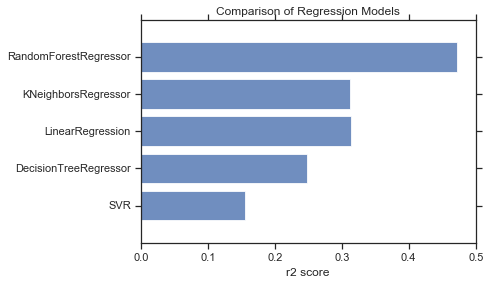

In [108]:
y_pos = range(len(results))
plt.barh(y_pos, results.values(), align='center', alpha=0.8)
plt.yticks(y_pos, results.keys())
plt.xlabel('r2 score')
plt.title('Comparison of Regression Models')
plt.show();

In [109]:
# R-square value tells you how much variation is explained by your model. 
reg_model = RandomForestRegressor(n_estimators=100)
reg_model.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [110]:
X_test.head()

,bathrooms,bedrooms,accommodates,review_scores_rating,room_type_Entire home/apt,room_type_Private room,room_type_Shared room,host_is_superhost_f,host_is_superhost_t,region_Central,region_East,region_North,region_South,region_West
9797,0.2500,0.5,0.600000,0.750000,1,0,0,1,0,1,0,0,0,0
4974,0.1250,0.1,0.066667,0.950000,0,1,0,1,0,0,0,0,1,0
748,0.1875,0.1,0.066667,1.000000,0,1,0,0,1,1,0,0,0,0
6062,0.1250,0.1,0.333333,0.952948,1,0,0,1,0,1,0,0,0,0
4294,0.2500,0.3,0.400000,0.887500,1,0,0,1,0,1,0,0,0,0


In [111]:
# https://towardsdatascience.com/running-random-forests-inspect-the-feature-importances-with-this-code-2b00dd72b92e
import pandas as pd
feature_importances = pd.DataFrame(reg_model.feature_importances_,
                                   index = X_train.columns,
                                   columns=['importance']).sort_values('importance', ascending=False)

feature_importances.head(20)

,importance
bathrooms,0.405372
bedrooms,0.183992
accommodates,0.143036
review_scores_rating,0.141119
region_Central,0.034017
host_is_superhost_f,0.018149
host_is_superhost_t,0.016826
region_East,0.015484
region_West,0.015167
room_type_Entire home/apt,0.012211


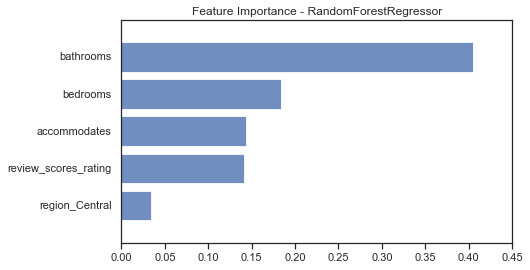

In [112]:
fig, ax = plt.subplots(figsize=(7, 4))

y_pos = range(0,5)
ax.barh(y_pos, feature_importances['importance'].values[0:5], align='center', alpha=0.8)
ax.set_yticks(y_pos)
ax.set_yticklabels(feature_importances.index.values[0:5])
ax.set_title("Feature Importance - RandomForestRegressor")
ax.tick_params(left=False, top=False, right=False) 
plt.gca().invert_yaxis()
plt.show();

In [113]:
features[['bathrooms', 'bedrooms', 'accommodates', 'review_scores_rating', 'region_Central']][:8]

,bathrooms,bedrooms,accommodates,review_scores_rating,region_Central
0,2.0,2.0,4,92.0,1
1,1.0,1.0,2,91.0,1
2,1.0,1.0,3,96.0,1
3,1.0,1.0,2,98.0,0
5,1.0,1.0,3,99.0,1
7,2.0,2.0,5,94.0,1
8,2.0,3.0,6,98.0,0
9,1.0,1.0,2,98.0,0


In [114]:
price_actual = price[:8].values
price_predict = reg_model.predict(features_scaled[:8])
print(price_predict)

[ 189.79666667  104.66719444  116.706        45.93145323  131.92411117
  232.00333333  261.65059524   45.39167462]


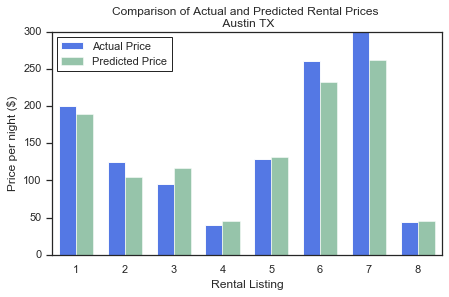

In [115]:
fig, ax = plt.subplots(figsize=(7, 4))

# https://matplotlib.org/examples/api/barchart_demo.html
ind = np.arange(0,8)
pad = 0.15
width = 0.35
set_actual = ax.bar(pad+ind, price_actual, width, color='royalblue', alpha=0.9)
set_predict = ax.bar(pad+ind+width, price_predict, width, color='seagreen', alpha=0.5)

ax.set_ylabel('Price per night ($)')
ax.set_xlabel('Rental Listing')
ax.set_title('Comparison of Actual and Predicted Rental Prices \n Austin TX')
ax.set_xticks(pad + ind + width)
ax.set_xticklabels((list(range(1,9))))
ax.legend( (set_actual, set_predict), ('Actual Price', 'Predicted Price'), loc='upper left')
ax.tick_params(bottom=False, top=False, right=False)

plt.show();